In [46]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering, AffinityPropagation, KMeans, MeanShift, estimate_bandwidth
from sklearn import metrics
from scipy.spatial.distance import cdist
import random
sns.set_style('darkgrid')
plt.rcParams['image.cmap'] = 'autumn'

In [2]:
df = pd.read_csv('results13.csv')
splits = ['5k', '10k', '20k', 'half', '25k', '35k', '40k']
cond = pd.DataFrame()
for split in splits:
    cond[split] = (df[split] == '-')
    
df = df[~cond.any(axis=1)].copy() #drop rows with null splits values
splits.append('official')

In [3]:
df.columns

Index(['25k', 'age', 'name', 'division', '10k', 'gender', 'half', 'official',
       'bib', 'ctz', 'country', 'overall', 'pace', 'state', '30k', '5k',
       'genderdiv', '20k', '35k', 'city', '40k'],
      dtype='object')

In [4]:
df.iloc[:, 12:].head()

,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [5]:
df.iloc[:, :12].head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,country,overall
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,CAN,9
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,KEN,5
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,ETH,1
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,AUS,5
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,JPN,3


In [6]:
df.columns

Index(['25k', 'age', 'name', 'division', '10k', 'gender', 'half', 'official',
       'bib', 'ctz', 'country', 'overall', 'pace', 'state', '30k', '5k',
       'genderdiv', '20k', '35k', 'city', '40k'],
      dtype='object')

In [7]:
data = pd.DataFrame(index=df.index)
        
data['5k'] = df['5k'].apply(float)
data['10k'] = df['10k'].apply(float)
data['20k'] = df['20k'].apply(float)
data['half'] = df['half'].apply(float)
data['25k'] = df['25k'].apply(float)
data['35k'] = df['35k'].apply(float)
data['40k'] = df['40k'].apply(float)
data['official'] = df['official'].apply(float)
data['pace'] = df.pace
data['age'] = df.age

data['male'] = np.where(df.gender == 'M', 1, 0)

def get_wheelchair(strng):
    """Takes a bib number in string format. Returns 1 when
    starts with "W" (wheelchair), otherwise 0.
    """
    if strng[0] == 'W':
        return 1
    else:
        return 0
    
data['wheelchair'] = df.bib.apply(get_wheelchair)

df = pd.concat([df, data[['male', 'wheelchair']]], axis=1)

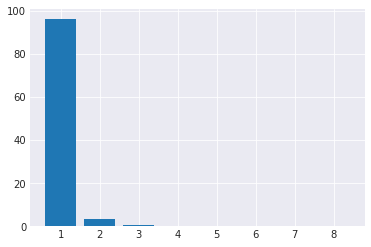

In [8]:
splt = data[splits]
splt_scl = StandardScaler()
splt_scl.fit(splt)
splt = splt_scl.transform(splt)
splt_pca = PCA()
splt_comp = splt_pca.fit_transform(splt)
vars_ = splt_pca.explained_variance_ratio_
plt.bar(range(1, 1+vars_.shape[0]), 100*vars_);
plt.show();

In [9]:
features = pd.DataFrame(index=df.index)
features['splits1'] = splt_comp[:, 0]
features['splits2'] = splt_comp[:, 1]
features['age'] = df.age
features = pd.DataFrame(index=df.index, columns=features.columns, data=normalize(features))
#features.head()

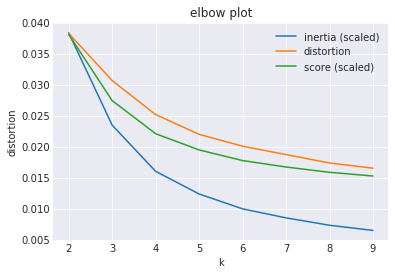

In [45]:
inrts = []
ks = []
distortions = []
scores = []
for k in range(2, 10):
    ks.append(k)
    clstr = KMeans(n_clusters=k, random_state=k*k)
    X = features[['splits1', 'splits2', 'age']]
    clstr = clstr.fit(X)
    inrts.append(clstr.inertia_)
    distortions.append(sum(np.min(cdist(X, clstr.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    scores.append(clstr.score(X))
    
plt.plot(ks, np.array(inrts)/1010, label='inertia (scaled)');    
plt.plot(ks, distortions, label='distortion');   
plt.plot(ks, (-np.array(scores)+15)/1410, label='score (scaled)');
plt.title('elbow plot')
plt.xlabel('k');
plt.ylabel('distortion');
plt.legend();
plt.show();

In [11]:
clstr = KMeans(n_clusters=4, random_state=42)
clstr = clstr.fit(features)

In [21]:
def view_clusters(df, features, preds):
    """Takes a dataframe in normal space (df), a frame with corresponding features (features),
    and a fitted clusterer (clstr). Plots all kinds of good stuff.
    Returns cluster assignments for fun.
    """
    df['cluster'] = preds
    features['cluster'] = preds
    plt.figure(figsize=(10, 7))
    plt.scatter(df['official'], df.age, c=features.cluster)
    plt.xlabel('finish time');
    plt.ylabel('age');
    plt.show();
    plt.show();
    plt.figure(figsize=(10, 7))
    plt.scatter(features['splits1'], df.age, c=features.cluster)
    plt.xlabel('splits PC1')
    plt.ylabel('age')
    plt.show();
    clusters = list(df.cluster.unique())
    plt.figure(figsize=(10, 6))
    for clust in clusters:
        plt.hist(df[df.cluster==clust].official, label='cluster {}'.format(clust+1), alpha=.8)

    plt.hist(df.official, label='total distribution', alpha=.35, bins=30)
    plt.legend();
    plt.show();

    fig, ax = plt.subplots(1, len(clusters), figsize=(14, 5));
    for clust in clusters:
        cluster = df[df.cluster==clust]
        men = len(cluster[cluster.male==1])
        women = len(cluster) - men
        wheelchair = len(cluster[cluster.wheelchair == 1])
        foot = len(cluster) - wheelchair
        ax[clust].bar([1, 2, 3], [men, women, wheelchair])
        ax[clust].set_title('cluster {}'.format(clust+1))
        ax[clust].set_xticks([1, 2, 3])
        ax[clust].set_xticklabels(['men', 'women', 'chair'])
    plt.show();
    return df.cluster

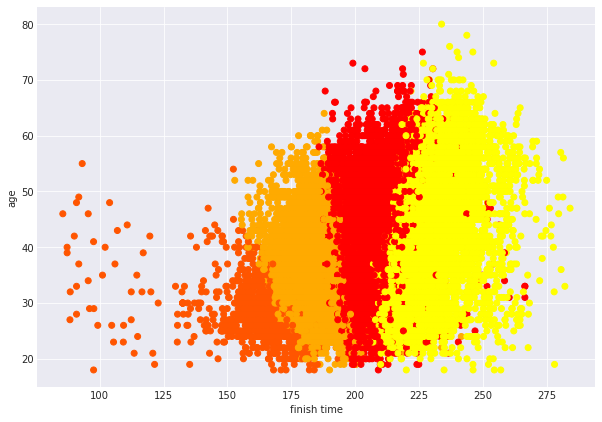

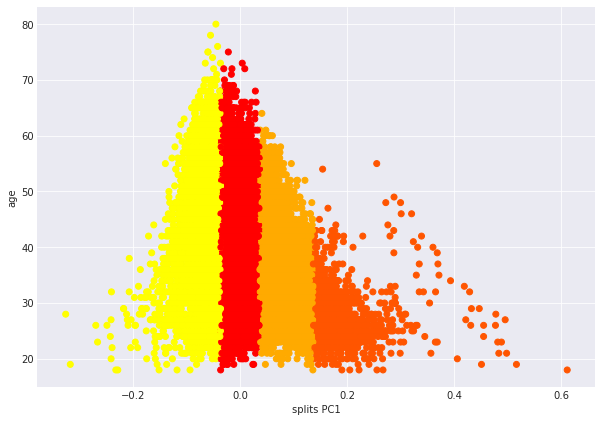

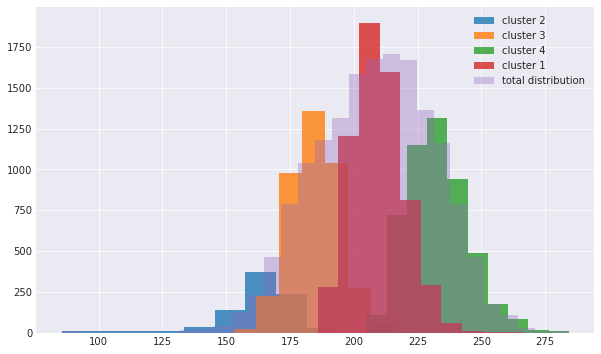

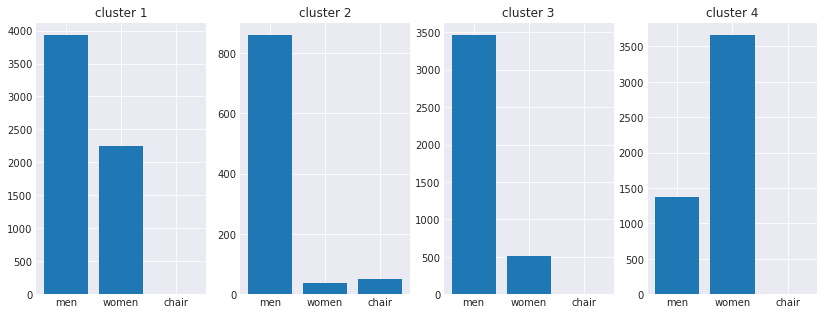

In [24]:
preds = clstr.predict(features[['splits1', 'splits2', 'age']])
tuf = view_clusters(df, features, preds)

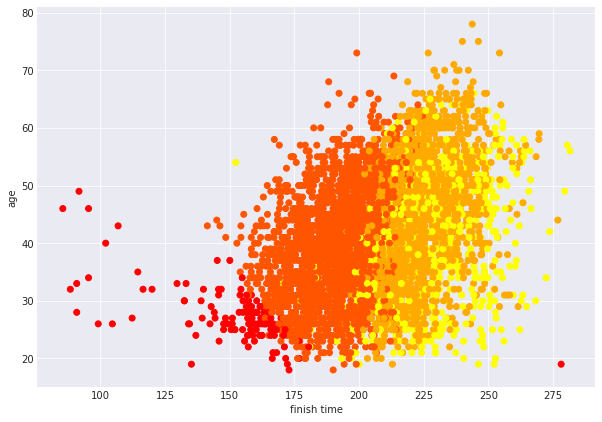

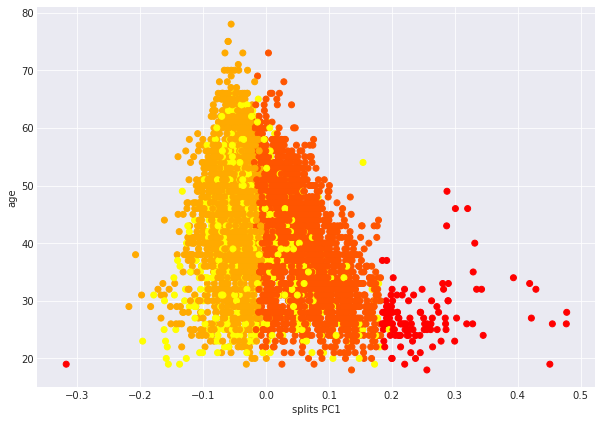

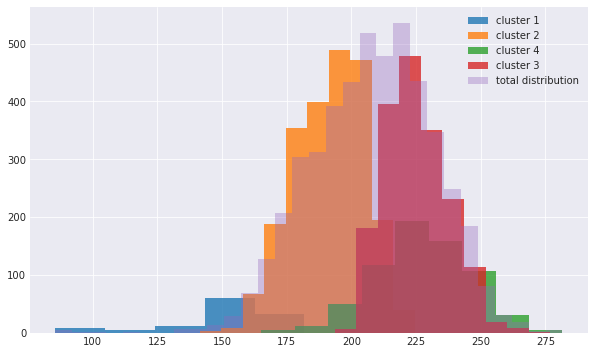

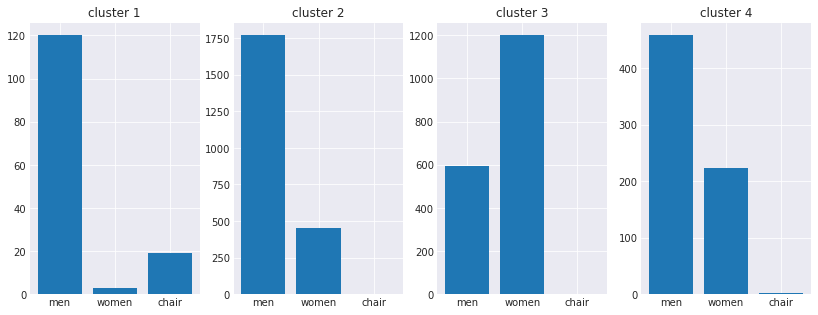

In [26]:
spectral = SpectralClustering(n_clusters=4)
X = features[['splits1', 'splits2', 'age']].sample(frac=.3, random_state=42)
indcs = X.index
preds = spectral.fit_predict(X)
braf = view_clusters(df.loc[indcs], X, preds)

In [47]:
bandwidth = estimate_bandwidth(X)

In [49]:
mshift = MeanShift(bandwidth=bandwidth)
mshift.fit(X)

MeanShift(bandwidth=0.051088327077768218, bin_seeding=False, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

In [52]:
mshift.cluster_centers_.shape

16058

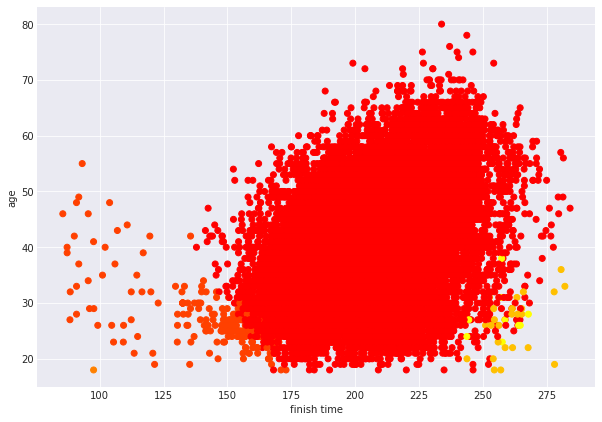

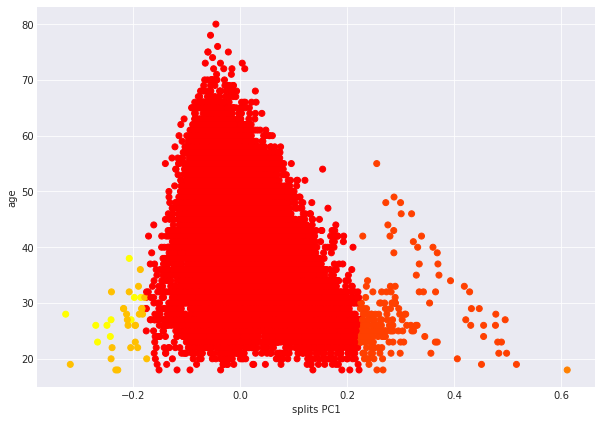

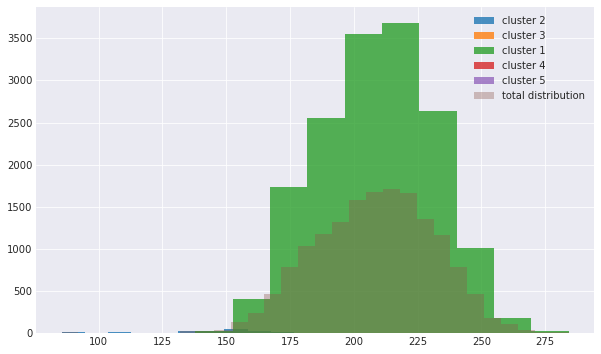

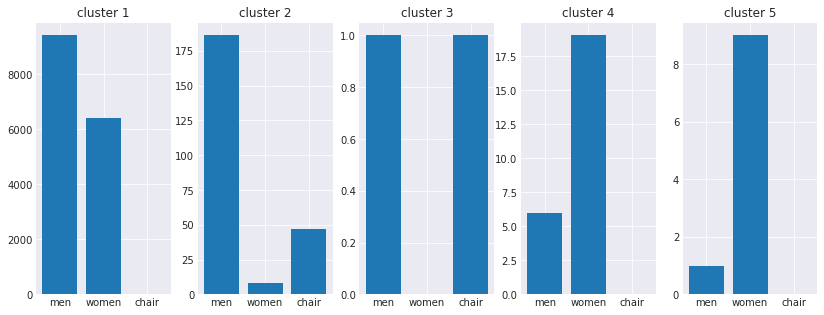

In [53]:
preds = mshift.predict(X)
braf = view_clusters(df, X, preds)

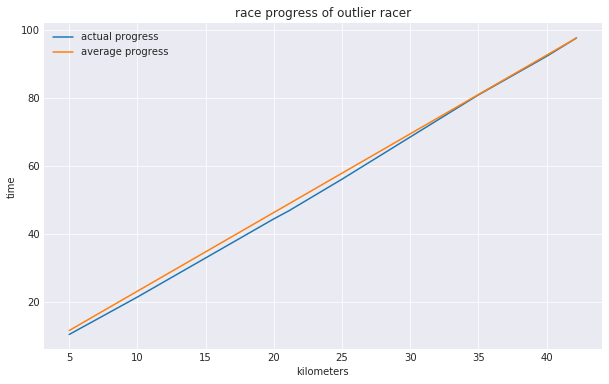

In [97]:
df['meanshift_clusters'] = preds
solo = df[df.meanshift_clusters == 2]
marks = np.array([5, 10, 20, 21.09, 25, 35, 40, 42.195])
times = solo[splits].values[0]
pace = times[-1] /42.195
expected_times = pace * marks
plt.figure(figsize=(10, 6))
plt.plot(marks, times, label='actual progress');
plt.plot(marks, expected_times, label='average progress');
plt.title('race progress of outlier racer');
plt.xlabel('kilometers');
plt.legend();
plt.ylabel('time');

In [117]:
df[(df.wheelchair==1) & (df.age < 21)][['age', 'name', 'official']]

,age,name,official
34,18,"Arkley, Nathenial",97.58
65,19,"Roy, Laurence D. III",135.23
66,19,"Martin, Raymond",121.48
100,20,"Moore, Jill N.",146.33


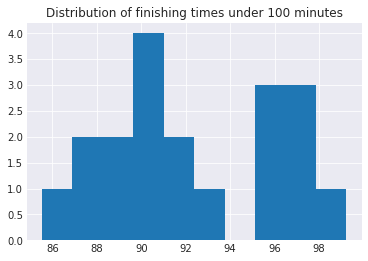

In [123]:
df[(df.wheelchair==1) & (df.official < 100)].official.hist();
plt.title('Distribution of finishing times under 100 minutes')
plt.show();

In [126]:
df.loc[df[df.wheelchair==1].official.sort_values().index][['age', 'official']]

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,5k,genderdiv,20k,35k,city,40k,male,wheelchair,cluster,meanshift_clusters
31,48.32,46,"Yamamoto, Hiroyuki",1,18.03,M,40.27,85.53,W20,NaN,...,8.87,1,38.23,71.18,Fukuoka,80.55,1,1,1,1
11,48.75,40,"Van Dyk, Ernst F.",2,18.18,M,40.57,87.20,W6,NaN,...,8.92,2,38.57,71.68,Paarl,81.88,1,1,1,1
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,8.92,3,38.55,71.68,Iizuka,81.88,1,1,1,1
13,48.75,27,"Hug, Marcel E.",4,18.18,M,40.57,88.32,W8,NaN,...,8.93,4,38.55,72.62,Nottwil,83.15,1,1,1,1
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,8.98,5,39.88,73.00,Hamilton,83.43,1,1,1,1
6,50.50,42,"Soejima, Masazumi",6,18.73,M,41.98,90.02,W4,NaN,...,8.98,6,39.87,74.00,Fukuoka,84.67,1,1,1,1
20,50.50,48,"Lemeunier, Denis",7,18.73,M,42.00,90.88,W14,NaN,...,8.98,7,39.88,75.03,Taule,85.57,1,1,1,1
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,8.90,9,38.80,74.73,Toronto,85.55,1,1,1,1
19,49.87,33,"Madera, Jorge",8,18.20,M,40.93,90.90,W13,NaN,...,8.93,8,38.80,74.75,Les Franquesas,85.57,1,1,1,1
8,52.62,49,"Schabort, Krige",11,19.77,M,43.97,91.78,W5,NaN,...,9.38,11,41.77,75.95,Cedartown,86.48,1,1,1,1
